## Simulate reaction A+B>B using Spatiocyte algorithm at various ka/kD ratio

In [1]:
from ecell4 import *
import numpy as np
import math
import sys

def singlerun(kaf,run):
    import numpy as np
    duration =0.05 #simulation duration
    rng = GSLRandomNumberGenerator()
    rng.seed(run)
    rm = 0.005
    voxelr=rm*1.0208582  #voxel radius
    L = 350*rm #length of cubic comparment
    D = 1 #diffusion coefficient
    kd= 4.0*math.pi*D*2*rm
    ka = kaf*kd
    kon = (ka*kd)/(ka+kd)
    tm =(2*voxelr)**2/(6*D)
    N = 4000 #number of molecules
    dt=tm
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    with species_attributes():
        A |  {'D': str(0), 'radius':str(voxelr)}
        B |  {'D': str(D), 'radius':str(voxelr)}

    with reaction_rules():
        A + B > B | ka
    m2 = get_model()
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
    w.bind_to(m2)
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    tlog = dt
    tlogs=[]
    nlog=[]
    while sim.t()<duration:
        if sim.t()>=tlog:
            tlogs.append(sim.t())
            nlog.append(w.num_particles_exact(Species('A')))
            tlog+=dt
        sim.step()
    name = 'data/kfac'+str(kaf)+'/run'+str(run)
    filename=open(name,'w')
    #saving time series of number of molecule at each run
    np.savetxt(name,np.column_stack((tlogs,nlog)),delimiter=',',fmt='%s')
    filename.close()  
    return

simrun=2 #30000 #number of simulation run used in the paper
kaf=1 #ka/kD ratio: 0.1,1,100
for run in range(simrun):
    singlerun(kaf,run)


### averaging over number of runs

In [2]:
import os
namelist=os.listdir("data/kfac"+str(kaf)+"/")
norun=len(namelist)
dat=np.loadtxt("data/kfac"+str(kaf)+'/'+namelist[0],delimiter=',')
l=dat.shape[0]
N=np.zeros(l)
i=0
for name in namelist:
    dat = np.loadtxt("data/kfac"+str(kaf)+'/'+name,delimiter=',')
    assert dat.shape[0]==l
    tt = dat[:,0]
    N+= dat[:,1]
    i+=1
Nm = N/i #average number of molecules

### Function to calculate survival probability and reaction rate constant from time series of number of molecules 

In [3]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import curve_fit
from math import sqrt

rm = 0.005  
D = 1
kd= 4.0*math.pi*D*2*rm
r0=0.256318
f=1.0208582
C = 0.413497
voxelr=f*rm
Na=4000
Nb=4000

#Collins-kimball theory for rate coefficient at large time
def latkt(t,kon,B):
    return kon * (1 + B / np.sqrt(t))

#integration of rate coefficient at large time
def intkt(t,A,B):  
    return A * (t + B * np.sqrt(t))

#calculate rate coefficient from survival probability
def calk(stsim,t,C): 
    dst = (stsim[2:]-stsim[:-2])/(t[2:]-t[:-2])
    dst=np.append((stsim[1]-stsim[0])/(t[1]-t[0]),dst)
    dst=np.append(dst,(stsim[-1]-stsim[-2])/(t[-1]-t[-2])  )
    return dst/stsim/-C

#calculate survival probability from time series
def stt(ikt,Cb): 
    return np.array([np.exp(-i*Cb) for i in ikt])

error = lambda x,y: (x-y)*100/x

def plotk(dat,k_factor,lag,ts,L):    
    print('ka/kD='+str(k_factor))
    lag1=lag[0]
    lag2=lag[1]
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    Vr = w.calculate_volume(ones()*L,voxelr)
    ka = k_factor*kd
    kon = (ka*kd)/(ka+kd)
    aeff = ka * (2 * rm) / (ka + kd)
    Bck = aeff/math.sqrt(D*math.pi) 
    Cb=Nb/Vr
    
    tkt=dat[:,0][::lag1]
    tst=dat[:,0][::lag2]
    mnac=dat[:,1]
    stsim = mnac/Na
    ksim = calk(stsim[::lag1],tkt,Cb)
    inx=(tkt>ts[0])*(tkt<ts[1])
    inx2=(tst>ts[0])*(tst<ts[1])
    stck = stt(intkt(tst,kon,2*Bck),Cb)
    ktck=latkt(tkt,kon,Bck)
    
    #fit simulated rate coefficient  
    def ffit(ksim): 
        std=np.loadtxt('/home/chew/outputdata/kfacc'+str(k_factor)+'_700_4000_4000_std_lag'+str(lag1),delimiter=',')
        popt,pcov = curve_fit(latkt,tkt[inx],ksim[inx],p0=[kon,Bck],sigma=std[inx],absolute_sigma=True)#,bounds=(0,[np.inf,1,np.inf]))#,sigma=weight,absolute_sigma=False)
        perr = np.sqrt(np.diag(pcov))
        r1=ksim[inx]-latkt(tkt[inx],*popt)
        print('sq er fit1',sum(r1**2))
        print('C1theory={:.6},C1={:.6},error={:.6}%,pm{:.6}'.format(kon,popt[0],error(kon,popt[0]),perr[0])) 
        aeffit = popt[1]*sqrt(math.pi*D)
        stdaeffit = perr[1]*sqrt(math.pi*D)
        print('C2theory={:.6},C2={:.6},error={:.6}%,pm{:.6}'.format(Bck,popt[1],error(Bck,popt[1]),perr[1]))          
        return popt

    popt1=ffit(ksim)    

    #graphs
    NK=kon
    lw=3
    fs=25
    ms=12
    ax1.plot(tkt,ksim/NK,'.',label='Simulation ($k_a/k_D=$'+str(k_factor)+')',markersize=ms-5)
    ax1.plot(tkt,ktck/NK,'-',label='Collins-Kimball theory ($k_a/k_D=$'+str(k_factor)+')',markersize=5,linewidth=lw)
    ax1.set_ylim(0.98,1.2)
    ax1.set_ylabel('k(t)/keff',fontsize=fs)
    ax1.set_xlabel('time (s)',fontsize=fs)
    ax1.tick_params(labelsize=fs)      
    ax1.legend(loc='best',fontsize=fs-2,frameon=False)
    ax1.set_xlim(ts[0],ts[1])       

    ax2.plot(tst[inx2],stsim[::lag2][inx2],'.',label='Simulation ($k_a/k_D=$'+str(k_factor)+')',markersize=ms)        
    ax2.plot(tst,stck,'-',label='Collins-Kimball theory ($k_a/k_D=$'+str(k_factor)+')',linewidth=lw)    
    ax2.set_ylabel('Survival probability',fontsize=fs)
    ax2.set_xlabel('time (s)',fontsize=fs)
    ax2.tick_params(labelsize=fs)
    ax2.legend(loc='best',fontsize=fs-2,frameon=False)

### Load data used in the paper, compute survival probability and reaction rate coefficient, then perform curve fitting

ka/kD=0.1
sq er fit1 3.3731679462762026e-07
C1theory=0.011424,C1=0.0114227,error=0.0112644%,pm0.00117683
C2theory=0.0005129,C2=0.000541337,error=-5.54447%,pm0.0114104
ka/kD=1
sq er fit1 2.2380453147046957e-06
C1theory=0.0628319,C1=0.062848,error=-0.0256779%,pm0.00296482
C2theory=0.00282095,C2=0.00279166,error=1.03817%,pm0.00519348
ka/kD=100
sq er fit1 4.225162676222361e-06
C1theory=0.12442,C1=0.124459,error=-0.031825%,pm0.00455523
C2theory=0.00558604,C2=0.00562918,error=-0.772293%,pm0.0039999


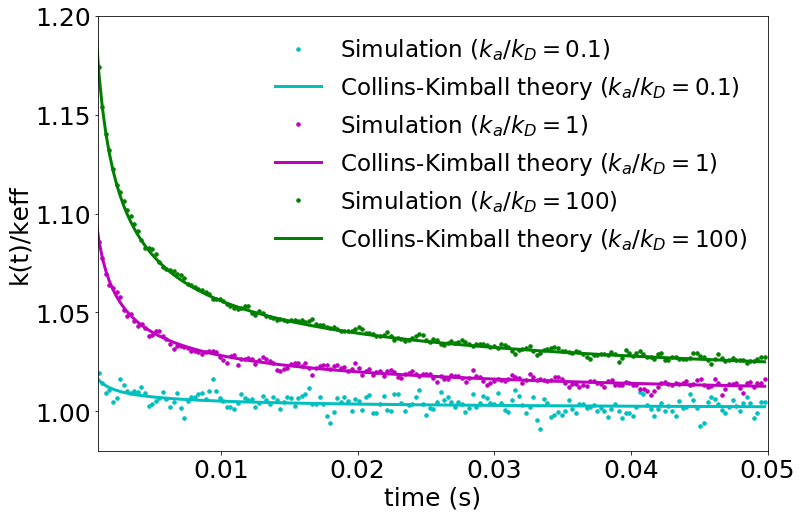

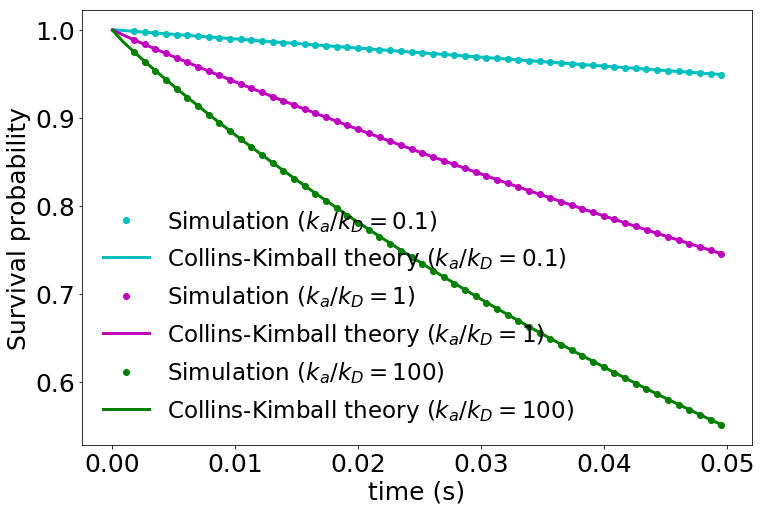

In [4]:
from cycler import cycler
t1=1e-3
t2=0.05
start=[t1,t2] #time range of interest
ds=[15,50] #downsampling factor for rate and survival probability
fig1,ax1=plt.subplots(1,1,figsize=(12,8))
fig2,ax2=plt.subplots(1,1,figsize=(12,8))
ax1.set_prop_cycle(cycler('color', ['c', 'c','m','m','g', 'g']) )
ax2.set_prop_cycle(cycler('color', ['c', 'c','m','m','g', 'g']) )

dat = np.loadtxt('/home/chew/outputdata/kfacc0.1_700_4000_4000',delimiter=',')
plotk(dat,0.1,ds,[t1,t2],700*rm)

dat = np.loadtxt('/home/chew/outputdata/kfacc1_700_4000_4000',delimiter=',')
plotk(dat,1,ds,[t1,t2],700*rm)

dat = np.loadtxt('/home/chew/outputdata/kfacc100_700_4000_4000',delimiter=',')
plotk(dat,100,ds,[t1,t2],700*rm)

